In [1]:
import pandas as pd
import numpy as np
import cupy as cp  # CuPy for GPU arrays 
import matplotlib.pyplot as plt
import os

# from rdkit import Chem
# from rdkit.Chem import Descriptors
# from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.plotting

In [2]:
# Parity plotter 
# ===========================================================================================
def plot_parity_with_metrics(target_name, data, metrics, save_path=None):
    """
    Creates a parity (observed vs. predicted) plot for train and test sets,
    annotated with MSE and R² metrics.
    """
    observed_train = data["train_observed"]
    predicted_train = data["train_predicted"]
    observed_test = data["test_observed"]
    predicted_test = data["test_predicted"]

    train_mse = metrics["train_mse"]
    test_mse = metrics["test_mse"]
    test_r2 = metrics["test_r2"]

    plt.figure(figsize=(8, 6))
    plt.scatter(observed_train, predicted_train, label="Train", color="blue", alpha=0.6)
    plt.scatter(observed_test, predicted_test, label="Test", color="red", alpha=0.6)

    # Plot perfect-fit line
    min_val = min(observed_train.min(), observed_test.min())
    max_val = max(observed_train.max(), observed_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", label="Perfect Fit")

    # Text box with metrics
    metrics_text = (
        f"Train MSE: {train_mse:.2f}\n"
        f"Test MSE: {test_mse:.2f}\n"
        f"Test R²: {test_r2:.2f}"
    )
    plt.text(
        0.05, 0.95, metrics_text,
        transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.xlabel(f"Observed {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Parity Plot for {target_name}")
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.close()
    

In [ ]:
# ============================================================================
# Note that this a new excel sheet I generated 
# from the preprocessing script that is read in.
# ============================================================================


polystyrene_path = r"C:\Users\micha\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Excels\polystyrene-imputated-molecular-descriptor-includes-inj-volume-2-15-25.xlsx"
polystyrene       = pd.read_excel(polystyrene_path)

In [4]:
# Predict the 1D target "Solvent Ratio_1"  -- this only works for two pairs of solvents
ratio_list = polystyrene['Solvent Ratio_1'].values    # target: 1D array
meta_data  = polystyrene[["Solvents_1", "Solvents_2"]]  # for tracking solvent pairs only

In [5]:
# Drop columns that are not features (e.g., Polymer and solvents used for meta)
columns_to_drop = ["Polymer", "Solvents_1", "Solvents_2", "Solvent Ratio_1"]
feature_columns  = polystyrene.drop(columns=columns_to_drop).columns

X = polystyrene.drop(columns=columns_to_drop).values
y = polystyrene["Solvent Ratio_1"].values

In [6]:
print("Feature matrix X shape:", X.shape)
print("Target y shape:", y.shape)

Feature matrix X shape: (172, 172)
Target y shape: (172,)


In [7]:
# ============================================================================
# Split the data (80% train, 10% validation, 10% test)
# ============================================================================

# Split into train and temporary sets while returning row indices
X_train_np, X_temp_np, y_train_np, y_temp_np, idx_train, idx_temp = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42
)

# Split the temporary set equally into validation and test sets (10% each)
X_val_np, X_test_np, y_val_np, y_test_np, idx_val, idx_test = train_test_split(
    X_temp_np, y_temp_np, idx_temp, test_size=0.5, random_state=42
)

In [8]:
print(f"Train size: {X_train_np.shape[0]}")
print(f"Validation size: {X_val_np.shape[0]}")
print(f"Test size: {X_test_np.shape[0]}")

Train size: 137
Validation size: 17
Test size: 18


In [9]:
# ============================================================================
# Convert arrays to CuPy arrays for GPU training
# Note: With only ~200 samples, GPU training probably not be necessary.
# ============================================================================

X_train = cp.asarray(X_train_np)
y_train = cp.asarray(y_train_np)
X_val   = cp.asarray(X_val_np)
y_val   = cp.asarray(y_val_np)
X_test  = cp.asarray(X_test_np)
y_test  = cp.asarray(y_test_np)

In [10]:
# ============================================================================
# Define the hyperparameter tuning objective function (Hyperopt)
# ============================================================================

def objective(params):
    # Convert integer parameters to int type
    params['n_estimators']           = int(params['n_estimators'])
    params['max_depth']              = int(params['max_depth'])
    params['learning_rate']          = float(params['learning_rate'])
    params['gamma']                  = float(params['gamma'])
    params['min_child_weight']       = int(params['min_child_weight'])
    params['subsample']              = float(params['subsample'])
    params['colsample_bytree']       = float(params['colsample_bytree'])
    # params['colsample_bylevel']      = float(params['colsample_bylevel'])
    # params['colsample_bynode']       = float(params['colsample_bynode'])
    params['reg_alpha']              = float(params['reg_alpha'])
    params['reg_lambda']             = float(params['reg_lambda'])
    
    # Force GPU usage in XGBoost 2.1.4 -- my current version
    params['tree_method']            = 'hist'
    params['device']                 = 'cuda'
    params['max_bin']                = int(params['max_bin'])
    params['max_cat_threshold']      = int(params['max_cat_threshold'])
    
    
    ### We may want to look into setting some monotonic constraints
    ### Or maybe even the more complicated interation_constraints
    ### or the max_cat_to_onehot param ---- can help interpretability 
    
    #############################################################################
    # Create and train the model on GPU arrays
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        early_stopping_rounds=10
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predict on the validation set
    y_pred_cp = model.predict(X_val)
    
    # Convert predictions and validation targets back to NumPy arrays
    y_pred_np = cp.asnumpy(y_pred_cp)
    y_val_np_conv = cp.asnumpy(y_val)
    
    mse = mean_squared_error(y_val_np_conv, y_pred_np)
    return {'loss': mse, 'status': STATUS_OK}

In [11]:
# Define the search space for hyperparameters
search_space = {
    'n_estimators':       hp.quniform('n_estimators', 50, 500, 10),
    'max_depth':          hp.quniform('max_depth', 3, 5, 1),
    'learning_rate':      hp.loguniform('learning_rate', -4, -1),
    'subsample':          hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree':   hp.uniform('colsample_bytree', 0.5, 1.0),
    # 'colsample_bylevel':  hp.uniform('colsample_bylevel', 0.5, 1.0),  # 50% to 100% per level
    # 'colsample_bynode':   hp.uniform('colsample_bynode', 0.5, 1.0),
    'reg_alpha':          hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda':         hp.loguniform('reg_lambda', -5, 2),
    'gamma':              hp.uniform('gamma', 0, 7),
    'min_child_weight':   hp.quniform('min_child_weight', 1, 5, 1),
    'max_bin':            hp.quniform('max_bin', 128, 1024, 16),
    'max_cat_threshold':  hp.quniform('max_cat_threshold', 16, 1024, 16)
}

In [12]:
# Run Hyperopt to tune hyperparameters
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2500,
    trials=trials
)
# Convert certain hyperopt parameters to int
best_params['n_estimators']           = int(best_params['n_estimators'])
best_params['max_depth']              = int(best_params['max_depth'])
best_params['learning_rate']          = float(best_params['learning_rate'])
best_params['gamma']                  = float(best_params['gamma'])
best_params['min_child_weight']       = int(best_params['min_child_weight'])
best_params['subsample']              = float(best_params['subsample'])
best_params['colsample_bytree']       = float(best_params['colsample_bytree'])
# best_params['colsample_bylevel']      = float(best_params['colsample_bylevel'])
# best_params['colsample_bynode']       = float(best_params['colsample_bynode'])
best_params['reg_alpha']              = float(best_params['reg_alpha'])
best_params['reg_lambda']             = float(best_params['reg_lambda'])

# Force GPU usage in XGBoost 2.1.4 -- my current version
best_params['tree_method']            = 'hist'
best_params['device']                 = 'cuda'
best_params['max_bin']                = int(best_params['max_bin'])
best_params['max_cat_threshold']      = int(best_params['max_cat_threshold'])
best_params["objective"]              = "reg:squarederror"
best_params["early_stopping_rounds"]  = 10



100%|██████████| 2500/2500 [11:31<00:00,  3.62trial/s, best loss: 6.587347899997973] 


In [13]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.8950602361555707, 'gamma': 4.278676407442219, 'learning_rate': 0.33118958257508757, 'max_bin': 192, 'max_cat_threshold': 32, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 180, 'reg_alpha': 0.2676284852073634, 'reg_lambda': 0.011811706976334628, 'subsample': 0.8076021096878109, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'reg:squarederror', 'early_stopping_rounds': 10}


In [14]:
# ============================================================================
# Evaluate using 5-fold cross-validation on CPU arrays
# This avoids issues with scikit-learn CV and GPU arrays.
# ============================================================================

cv_params = best_params.copy()

if "early_stopping_rounds" in cv_params:
    del cv_params["early_stopping_rounds"]
    
# Create a model using the best hyperparameters (for CV, use CPU arrays)
model_cv = xgb.XGBRegressor(**cv_params)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Use the CPU arrays (X_train_np, y_train_np) for CV
cv_scores = cross_val_score(model_cv, X_train_np, y_train_np, cv=kf, scoring='r2')

print("5-Fold CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [12:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


5-Fold CV R² scores: [0.92545788 0.6676377  0.84431829 0.91565159 0.74299717]
Mean CV R²: 0.8192125236152409


In [15]:
# ============================================================================
# Train the final model on GPU arrays with the tuned parameters
# ============================================================================

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=0
)

# Evaluate the final model on the test set
y_train_np_conv = cp.asnumpy(y_train)
y_test_np_conv  = cp.asnumpy(y_test)

# Train predictions
y_pred_train_cp = final_model.predict(X_train)
y_pred_train_np = cp.asnumpy(y_pred_train_cp)

# Test predictions
y_pred_test_cp = final_model.predict(X_test)
y_pred_test_np = cp.asnumpy(y_pred_test_cp)




train_mse = mean_squared_error(y_train_np_conv, y_pred_train_np)
test_mse  = mean_squared_error(y_test_np_conv,  y_pred_test_np)
test_r2   = r2_score(y_test_np_conv, y_pred_test_np)

parity_data = {
    "train_observed":   y_train_np_conv,
    "train_predicted":  y_pred_train_np,
    "test_observed":    y_test_np_conv,
    "test_predicted":   y_pred_test_np
}
parity_metrics = {
    "train_mse": train_mse,
    "test_mse":  test_mse,
    "test_r2":   test_r2
}

print(f"Final Model - (Tuned, GPU) Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

Final Model - (Tuned, GPU) Test MSE: 4.6967, R²: 0.9786


In [16]:
importances = final_model.feature_importances_  # 1D numpy array of importances
feature_importance_df = pd.DataFrame({
    "feature": feature_columns,
    "importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

print(feature_importance_df)

                                         feature  importance
129                               MinEStateIndex    0.273192
21                                         Chi3v    0.179647
123                            MaxAbsEStateIndex    0.163552
15                                       BertzCT    0.098141
30                                   EState_VSA3    0.061499
..                                           ...         ...
165                Stationary Phase_μStyragel HT    0.000000
167                         Base Material_Silica    0.000000
169  Base Material Modification_No Modifications    0.000000
170           Base Material Modification_Unknown    0.000000
171                                Phase_Reverse    0.000000

[172 rows x 2 columns]


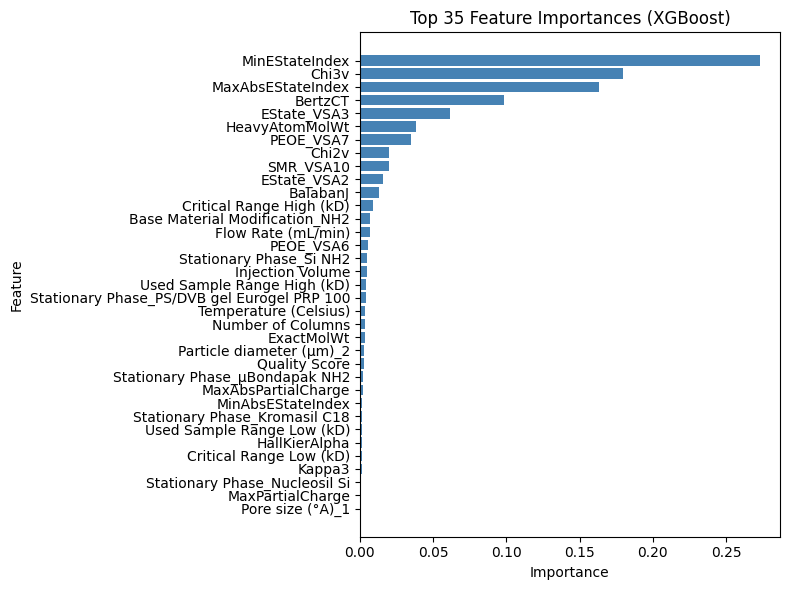

In [17]:
# Feature importance

save_dir1 = r"C:\Users\micha\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-features"
#save_dir = r"C:\Users\Dillo\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
os.makedirs(save_dir1, exist_ok=True)

top_n = 35
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["importance"], color="steelblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.gca().invert_yaxis()  # so that the highest importance is at the top
plt.tight_layout()
save_path1 = os.path.join(save_dir1, "feature_importances2-17-25-attempt2.png")
plt.savefig(save_path1, dpi=1200, bbox_inches="tight")
plt.show()

In [ ]:
# ============================================================================
# Saving polarity plots 
# ============================================================================

# Create a directory to save your plot (optional)
save_dir = r"C:\Users\micha\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
#save_dir = r"C:\Users\Dillo\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
os.makedirs(save_dir, exist_ok=True)

# Call the plotting function
plot_parity_with_metrics(
    target_name="Solvent Ratio_1",
    data=parity_data,
    metrics=parity_metrics,
    save_path=os.path.join(save_dir, "solvent_ratio_parity_plot2500-2-17-25-attempt2-molecular-desc.png")
)

In [19]:
# Keeps track of the original solvents along with predictions:

meta_test = meta_data.iloc[idx_test].reset_index(drop=True)

results_test = pd.DataFrame({
    "Solvents_1": meta_test["Solvents_1"],
    "Solvents_2": meta_test["Solvents_2"],
    "Observed": y_test_np_conv,
    "Predicted": y_pred_test_np
})

print(results_test)

           Solvents_1       Solvents_2  Observed  Predicted
0     Tetrahydrofuran           Hexane     56.40  51.652050
1     Tetrahydrofuran      Cyclohexane     82.00  82.763931
2              Hexane  Tetrahydrofuran     51.50  52.943180
3      Carbon Dioxide  Tetrahydrofuran     54.00  54.536530
4        Acetonitrile  Tetrahydrofuran     50.60  51.516289
5     Tetrahydrofuran            Water     86.00  85.893959
6     Tetrahydrofuran     Acetonitrile     50.00  52.413334
7              Hexane  Tetrahydrofuran     52.10  53.480843
8              Hexane  Tetrahydrofuran     59.00  56.441933
9     Dichloromethane     Acetonitrile     55.00  57.335602
10     Carbon Dioxide  Tetrahydrofuran     54.00  54.536530
11    Dichloromethane     Acetonitrile     57.00  54.759556
12  Dimethylacetamide     Acetonitrile     81.00  82.119064
13             Hexane    Ethyl Acetate     62.15  62.311749
14    Tetrahydrofuran            Water     87.70  87.484833
15    Dichloromethane     Acetonitrile  

avg best error: 6.587347899997973


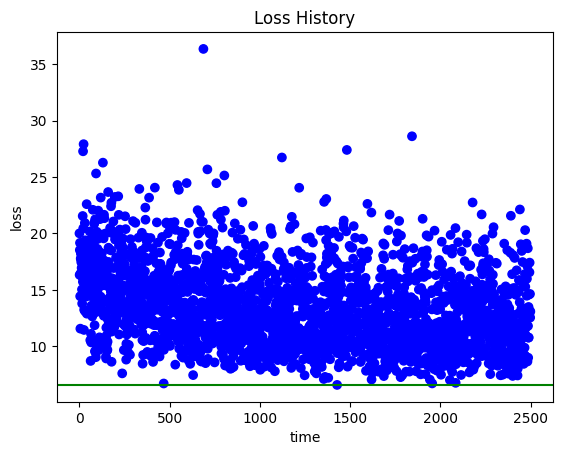

<Figure size 640x480 with 0 Axes>

Showing Histogram of 2500 jobs


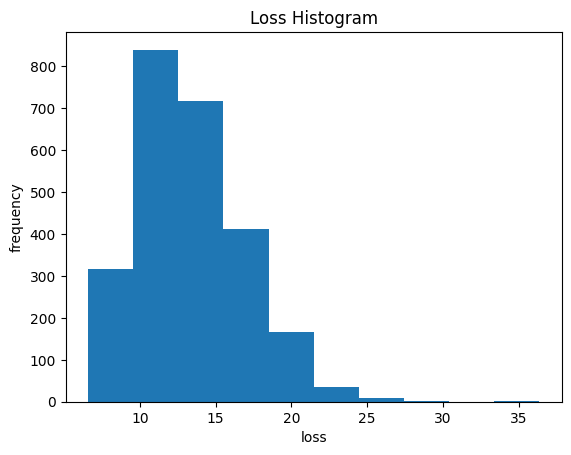

<Figure size 640x480 with 0 Axes>

finite loss range 6.587347899997973 36.34480062961232 5.587347899997973


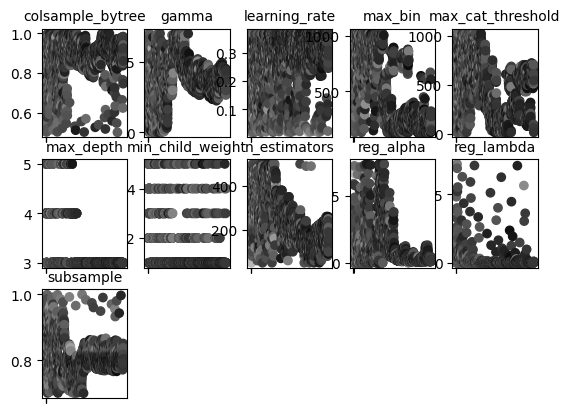

<Figure size 640x480 with 0 Axes>

In [20]:


# Plot how the loss function changed over the course of trials
hyperopt.plotting.main_plot_history(trials)
plt.savefig("hyperopt_history.png", dpi=1200, bbox_inches="tight")
plt.show()

# Plot a histogram of the loss
hyperopt.plotting.main_plot_histogram(trials)
plt.savefig("hyperopt_histogram.png", dpi=1200, bbox_inches="tight")
plt.show()

# Plot a summary of the variables that Hyperopt searched
hyperopt.plotting.main_plot_vars(trials)
plt.savefig("hyperopt_vars.png", dpi=1200, bbox_inches="tight")
plt.show()